In [250]:
import pandas as pd
df = pd.read_csv("../Data_120294_2023-03-29.csv")


/tmp/ipykernel_11445/3999482315.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data_120294_2023-03-29.csv")


In [251]:
desired_columns = ['thoracic_dgn', 'num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'init_creat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr', 'tx_date', 'init_date']

# Replace "ethnicity" with "ethcat" in desired_columns
desired_columns = ['thoracic_dgn', 'num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'init_stat', 'init_creat', 'init_age', 'ethcat', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr', 'tx_date', 'init_date']


df = df[desired_columns]

#Check number of missing values in  num_prev_tx
print(df['num_prev_tx'].isnull().sum())


0


[Text(0.5, 0, 'Percentage of missing values'),
 Text(0, 0.5, 'Number of columns')]

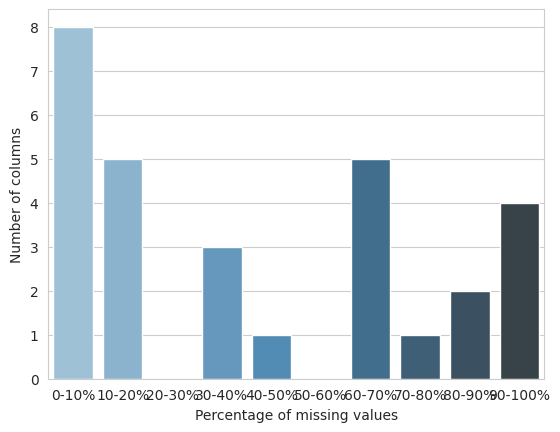

In [252]:
import seaborn as sns

missing_pct = df.isnull().sum() / len(df.index) * 100
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{i}-{j}%' for i, j in zip(bin_edges[:-1], bin_edges[1:])]

# Bin the columns according to their missing value percentage
bins = pd.cut(missing_pct, bins=bin_edges, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = bins.value_counts().sort_index()

# Create a bar plot of the bin counts
sns.set_style("whitegrid")
ax = sns.barplot(x=bin_counts.index, y=bin_counts.values, palette="Blues_d")
ax.set(xlabel="Percentage of missing values", ylabel="Number of columns")

In [253]:
# Remove rows with no transplant date
pre_len = len(df.index)
df = df[df['tx_date'].notna()]
post_len = len(df.index)
print(f"Filtered to only transplanted patients: {post_len}/{pre_len} ({post_len/pre_len*100:.2f}% remaining)")

# Compute the time to transplant (waitlist time -> wl_time)
df['wl_time'] = (pd.to_datetime(df['tx_date'], format='%d%b%Y') - pd.to_datetime(df['init_date'], format='%d%b%Y')).dt.days
df = df.drop(columns=['tx_date', 'init_date'])
print(f"Mean waitlist time: {df['wl_time'].mean():.2f} days")


Filtered to only transplanted patients: 77410/120264 (64.37% remaining)
Mean waitlist time: 192.53 days


In [254]:
# Remove columns where all values are missing
pre_len = len(df.columns)
df = df.dropna(axis=1, how='all')
post_len = len(df.columns)
print(f"Removed columns with all missing values: {pre_len-post_len}/{pre_len} ({(pre_len-post_len)/pre_len*100:.2f}% removed)")

# Remove columns where there is no variance
pre_len = len(df.columns)
df = df.loc[:, df.nunique() != 1]
post_len = len(df.columns)
print(f"Removed columns with no variance: {pre_len-post_len}/{pre_len} ({(pre_len-post_len)/pre_len*100:.2f}% removed)")

df_tmp = df.copy() # Will be used later for adding _missing columns


Removed columns with all missing values: 1/38 (2.63% removed)
Removed columns with no variance: 2/37 (5.41% removed)


In [255]:
# We need to find the categorical columns, use OrdinalEncoder to encode them first.
# Once encoded, we will impute the mising values using MissForest imputation. We will then revert the encoding back to the original categorical values and use OneHotEncoder to encode them.

from missingpy import MissForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Find the categorical columns using nunique
categorical_columns = df.nunique()[df.nunique() < 10].index.tolist()
categorical_column_indexes = [df.columns.get_loc(c) for c in categorical_columns if c in df]
# Print the number of of categorical columns
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")


# Create a new copied dataframe with only the cateogrical columns
#df_categorical = df[categorical_columns].copy()
#df_categorical.sample(10)
#
#ordinal_categorical_columns = ['education', 'diab', 'academic level'] # Behöver education och academic level ens encodas? De är väl redan det?
#label_caterogical_columns = ['tah', 'vas', 'onvent', 'inotropic', 'gender', 'abo', 'cereb_vasc', 'malig_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'ventilator_tcr', 'work_income_tcr', ]
#not_categorical_columns = ['num_prev_tx', ]
#question_mark = ['dial_ty_tcr', 'ecmo_tcr', 'iabp_tcr', 'inotopres_tcr', ]
#
## Count the number of items in each ordinal_categorical_columns, label_caterogical_columns, not_categorical_columns and question_mark
#print(f"Number of items in ordinal_categorical_columns: {len(ordinal_categorical_columns) + len(label_caterogical_columns) + len(not_categorical_columns) + len(question_mark)}")
#


# OBS! Kom ihåg att ethcat måste hanteras i enlighet med mail


ordinal_encoder = OrdinalEncoder()

# Encode the categorical columns
df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])
#Print samples


Number of categorical columns: 23
Categorical columns: ['num_prev_tx', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'cig_use', 'prior_card_surg_tcr', 'histry_cig_old', 'ethcat', 'ventilator_tcr', 'work_income_tcr', 'academic_level_tcr']


In [256]:
# Impute the missing values using MissForest

#Use first 1000 rows for df
df = df.iloc[:1000, :]

imputer = MissForest()
df = pd.DataFrame(imputer.fit_transform(df, cat_vars=categorical_column_indexes), columns=df.columns)


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 0


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 1


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 2


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

Iteration: 3


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 4


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

Iteration: 5


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 6


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors a

Iteration: 7


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers an

Iteration: 8


/home/maliti/Prog/time-to-transplantation/.conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [257]:
# Revert the encoding
df[categorical_columns] = ordinal_encoder.inverse_transform(df[categorical_columns])

df_tmp = df.copy()


In [258]:



# One hot encode the categorical columns
df = pd.get_dummies(df, columns=categorical_columns)

/tmp/ipykernel_11445/3696273928.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_11445/3696273928.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_11445/3696273928.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_11445/3696273928.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=categorical_columns)
/tmp/ipykernel_11445/3696273

In [259]:
df_tmp = df_tmp[desired_columns]

#Number of columns in df pre merge
print(f"Number of columns in df pre merge: {len(df.columns)}")

# For each column in the dataframe, add another column prefixed with missing_ that is True if the value is missing and False otherwise
for col in df_tmp.columns:
    df[f'{col}_missing'] = df_tmp[col].isnull().astype(int)

#Number of columns in df post merge
print(f"Number of columns in df post merge: {len(df.columns)}")

df_tmp.sample(10)




/tmp/ipykernel_11445/1388580130.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tmp = pd.read_csv("../Data_120294_2023-03-29.csv")


Number of columns in df pre merge: 87
Number of columns in df post merge: 126


,thoracic_dgn,num_prev_tx,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,...,ethcat,init_hgt_cm_calc,init_wgt_kg_calc,ventilator_tcr,lvad_at_listing,rvad_at_listing,work_income_tcr,academic_level_tcr,tx_date,init_date
8387,1000,0,NaN,NaN,NaN,NaN,NaN,M,B,86.1830,...,1,180.34,86.1830,0,NaN,NaN,NaN,NaN,NaN,07apr2017
19071,1000,0,NaN,NaN,NaN,NaN,NaN,M,O,60.0000,...,1,177.80,60.0000,0,NaN,NaN,NaN,NaN,NaN,02dec2005
58007,1200,0,N,N,N,N,N,M,A,88.4500,...,1,185.00,88.4500,0,NaN,NaN,NaN,NaN,15jul1997,12jan1995
90213,1000,0,NaN,NaN,NaN,NaN,NaN,F,A,33.3000,...,1,138.90,33.3000,0,NaN,NaN,NaN,1.0,22nov2011,16jun2011
66865,1000,0,NaN,NaN,NaN,NaN,NaN,F,A,66.2245,...,1,170.18,66.2245,0,NaN,NaN,NaN,NaN,02oct1999,11aug1999
40147,1000,0,NaN,NaN,NaN,NaN,NaN,F,O,94.5000,...,2,165.10,94.5000,0,NaN,NaN,NaN,NaN,NaN,13jul2018
83219,1007,0,NaN,NaN,NaN,NaN,NaN,M,A,81.3630,...,1,175.26,81.1930,0,1.0,NaN,N,NaN,14mar2009,05mar2009
114759,1049,0,NaN,NaN,NaN,NaN,NaN,M,A,93.3500,...,2,180.34,93.3500,0,NaN,NaN,N,NaN,10jun2019,12dec2018
98907,1000,0,NaN,NaN,NaN,NaN,NaN,F,O,12.9000,...,4,86.00,12.9000,0,NaN,NaN,NaN,996.0,25dec2014,15apr2014
78576,1007,0,NaN,NaN,NaN,NaN,NaN,M,O,101.6050,...,1,183.00,101.6050,0,1.0,NaN,N,NaN,22dec2008,26aug2008


In [260]:
df.to_csv("../Data_120294_2023-03-29_cleaned.csv", index=False)

df.sample(10)


,thoracic_dgn,wgt_kg_tcr,hgt_cm_tcr,func_stat_tcr,most_rcnt_creat,tot_serum_album,hemo_co_tcr,init_stat,init_age,init_hgt_cm_calc,...,ethcat_missing,init_hgt_cm_calc_missing,init_wgt_kg_calc_missing,ventilator_tcr_missing,lvad_at_listing_missing,rvad_at_listing_missing,work_income_tcr_missing,academic_level_tcr_missing,tx_date_missing,init_date_missing
400,1007.0,76.6600,180.00,2.0,1.063,4.213,3.9000,2030.0,53.0,180.0000,...,0,0,0,0,1,1,1,1,1,0
32,1000.0,16.0000,107.90,4010.0,0.400,3.200,2.2388,2020.0,5.0,108.0000,...,0,0,0,0,1,1,1,1,1,0
463,1000.0,22.6800,48.00,996.0,0.574,3.530,1.9946,2030.0,6.0,71.2716,...,0,0,0,0,1,1,1,1,1,0
568,1999.0,72.0000,180.00,998.0,1.665,4.227,4.2777,2030.0,63.0,180.0000,...,0,0,0,0,1,1,1,1,1,0
701,1007.0,86.6361,177.80,996.0,2.200,3.600,5.5000,2010.0,64.0,177.8000,...,0,0,0,0,1,1,1,1,1,0
216,1005.0,69.8500,185.00,998.0,1.737,4.318,4.6000,2030.0,47.0,185.0000,...,0,0,0,0,1,1,1,1,1,0
464,1000.0,58.9670,167.64,996.0,0.800,3.396,2.9000,2020.0,25.0,167.6400,...,0,0,0,0,1,1,1,1,1,0
601,1000.0,113.3980,177.80,2030.0,1.300,2.700,5.3000,2020.0,30.0,177.8000,...,0,0,0,0,1,1,1,1,1,0
159,1007.0,74.8427,182.88,996.0,1.300,2.900,3.0000,2020.0,62.0,182.8800,...,0,0,0,0,1,1,1,1,1,0
138,1200.0,64.0000,180.00,996.0,1.516,3.293,3.9849,2090.0,59.0,180.0000,...,0,0,0,0,1,1,1,1,1,0
